# What is the True Normal Human Body Temperature? 

#### Background

The mean normal body temperature was held to be 37$^{\circ}$C or 98.6$^{\circ}$F for more than 120 years since it was first conceptualized and reported by Carl Wunderlich in a famous 1868 book. But, is this value statistically correct?

<h3>Exercises</h3>

<p>In this exercise, you will analyze a dataset of human body temperatures and employ the concepts of hypothesis testing, confidence intervals, and statistical significance.</p>

<p>Answer the following questions <b>in this notebook below and submit to your Github account</b>.</p> 

<ol>
<li>  Is the distribution of body temperatures normal? 
    <ul>
    <li> Although this is not a requirement for the Central Limit Theorem to hold (read the introduction on Wikipedia's page about the CLT carefully: https://en.wikipedia.org/wiki/Central_limit_theorem), it gives us some peace of mind that the population may also be normally distributed if we assume that this sample is representative of the population.
    <li> Think about the way you're going to check for the normality of the distribution. Graphical methods are usually used first, but there are also other ways: https://en.wikipedia.org/wiki/Normality_test
    </ul>
<li>  Is the sample size large? Are the observations independent?
    <ul>
    <li> Remember that this is a condition for the Central Limit Theorem, and hence the statistical tests we are using, to apply.
    </ul>
<li>  Is the true population mean really 98.6 degrees F?
    <ul>
    <li> First, try a bootstrap hypothesis test.
    <li> Now, let's try frequentist statistical testing. Would you use a one-sample or two-sample test? Why?
    <li> In this situation, is it appropriate to use the $t$ or $z$ statistic? 
    <li> Now try using the other test. How is the result be different? Why?
    </ul>
<li>  Draw a small sample of size 10 from the data and repeat both frequentist tests. 
    <ul>
    <li> Which one is the correct one to use? 
    <li> What do you notice? What does this tell you about the difference in application of the $t$ and $z$ statistic?
    </ul>
<li>  At what temperature should we consider someone's temperature to be "abnormal"?
    <ul>
    <li> As in the previous example, try calculating everything using the boostrap approach, as well as the frequentist approach.
    <li> Start by computing the margin of error and confidence interval. When calculating the confidence interval, keep in mind that you should use the appropriate formula for one draw, and not N draws.
    </ul>
<li>  Is there a significant difference between males and females in normal temperature?
    <ul>
    <li> What testing approach did you use and why?
    <li> Write a story with your conclusion in the context of the original problem.
    </ul>
</ol>

You can include written notes in notebook cells using Markdown: 
   - In the control panel at the top, choose Cell > Cell Type > Markdown
   - Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

#### Resources

+ Information and data sources: http://www.amstat.org/publications/jse/datasets/normtemp.txt, http://www.amstat.org/publications/jse/jse_data_archive.htm
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

****

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm
import statsmodels

df = pd.read_csv('data/human_body_temperature.csv')

In [2]:
df.head()

,temperature,gender,heart_rate
0,99.3,F,68.0
1,98.4,F,81.0
2,97.8,M,73.0
3,99.2,F,66.0
4,98.0,F,73.0


In [3]:
df.shape

(130, 3)

## 1. Is the distribution of body temperatures normal?

#### Histogram
Before we use any sort of fancy tools, the bottom line: does it look normal?

We plot the distribution of body temperatures below. The small sample (130 observations) looks reasonably normal.

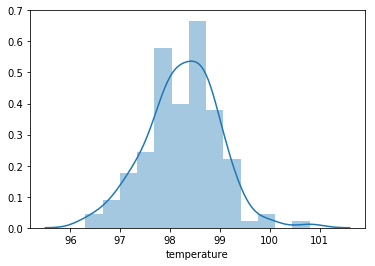

In [4]:
sns.distplot(df['temperature'])

#### Q-Q Plot
We can also compare our sample against normal distribution using Q-Q plot.

In [9]:
df['temperature'].describe()

count    130.000000
mean      98.249231
std        0.733183
min       96.300000
25%       97.800000
50%       98.300000
75%       98.700000
max      100.800000
Name: temperature, dtype: float64

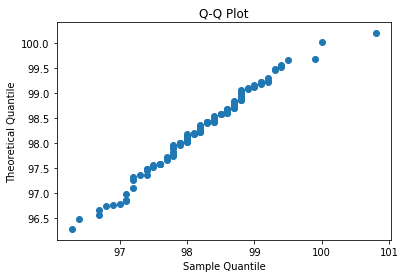

In [21]:
def qqplot(x, y, **kwargs):
    _, xr = stats.probplot(x, fit=False)
    _, yr = stats.probplot(y, fit=False)
    plt.scatter(xr, yr, **kwargs)
    plt.title('Q-Q Plot')
    plt.xlabel('Sample Quantile')
    plt.ylabel('Theoretical Quantile')

test = np.random.normal(98.25, 0.733, 130)

qqplot(df['temperature'], test)

A q-q plot is a plot of the quantiles of the one data set against the quantiles of another. In our case, one dataset is the temperature sample data and the other is a set of normally distributed points with the same mean and std as the sample. If our sample is normal, the Q-Q plot should be a 45 degree line.

And as the plot above shows, it is largely a 45 degree line. Now we have more reason to believe that the sample is normal.

#### One last thing: Normal Test

To confirm our finding from the plot, we can do a normal test. The normaltest function from scipy tests whether a sample differs from a normal distribution. The null hypothesis is that the sample comes from a normal distribution. As the result below shows, p-value = 0.259, we fail to reject the null.

At this point, it is safe to conclude that the distribution is normal.

In [22]:
stats.normaltest(df['temperature'])

NormaltestResult(statistic=2.703801433319203, pvalue=0.2587479863488254)

## 2a. Is the sample size large?

The data come from volunteers participating in Shigella vaccine trials conducted at the University of Maryland Center for Vaccine Development, Baltimore in 1992. So let the population size to be 731227, which was Baltimore's population in 1992. Using 95 percent confidence interval and 5 percent margin of error, we can calculate the sample size we need, which is 384 (based on sample size calculator https://www.surveymonkey.com/mp/sample-size-calculator/). Since we have only 130 observations in our data, the sample size is really small.

## 2b. Are the observations independent?

We can make residual plot to see whether the observations are independent.

In [42]:
from sklearn.preprocessing import normalize
df_norm = pd.DataFrame(normalize(df[['temperature', 'heart_rate']], axis=0))
df_norm.rename(columns={0:'temperature', 1:'heart_rate'}, inplace=True)

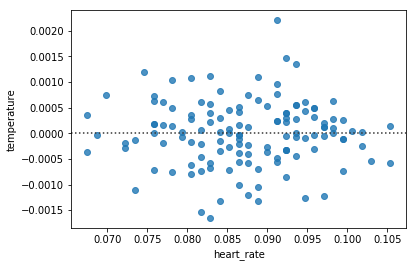

In [53]:
sns.residplot(df_norm['heart_rate'], df_norm['temperature'])

The pattern of the residuals appear to be random, which suggests that the observations are independent.

## 3. Is the true population mean really 98.6 degrees F?

#### Bootstrap hypothesis test

In [66]:
def bootstrap_replicate_1d(data, func):
    return func(np.random.choice(data, size=len(data)))

def draw_bs_reps(data, func, size=1):
    """Draw bootstrap replicates."""

    # Initialize array of replicates: bs_replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data, func)

    return bs_replicates

def diff(data):
    return np.mean(data)-98.6

trans_temp = df['temperature'] - np.mean(df['temperature']) + 98.6

# Take bootstrap replicates of temperatures
bs_replicates = draw_bs_reps(trans_temp, diff, 10000)

# Compute fraction of replicates that are less than the observed difference between sample mean and 98.6 degrees
p = np.sum(bs_replicates <= diff(df['temperature'])) / 10000

# Print the p-value
print('p = ', p)

p =  0.0


The null of the bootstrap hypothesis test is that the true mean of the sample is 98.6 degrees and the alternative hypothesis is that it is not 98.6 degrees. With a p-value of 0.0, we reject the null with 99 percent confidence.

#### Frequentist test: One-sample T-test

It is a one-sample test because we are trying to compare the sample with a theoretical population mean: 98.6. Only one sample is involved and the null hypothesis is the true population mean is 98.6. We choose to use t-test because the population standard deviation is not known.

In [59]:
stats.ttest_1samp(df['temperature'], popmean=98.6)

Ttest_1sampResult(statistic=-5.4548232923645195, pvalue=2.4106320415561276e-07)

According to the result, we reject null hypothesis with 99% confidence. Since the test statistic is -5.45, we conclude that the true population mean is less than 98.6 degrees.

#### Try the other test: One-Sample Z-test

In [63]:
statsmodels.stats.weightstats.ztest(df['temperature'], value=98.6)

(-5.4548232923645195, 4.9021570141012155e-08)

p-value = 4.9e-08.
Albeit inappropriate in this case, the Z-test yields similar results. We reject the null hypothesis at 99% confidence level and conclude that the true population mean is less than 98.6 degrees.

## 4. Draw a small sample of size 10 from the data and repeat both frequentist tests.

Draw a small sample of size 10. Take a look at its distribution. Apparently, it is not normal.

In [88]:
sample = df['temperature'].sample(n=10, random_state = 15)

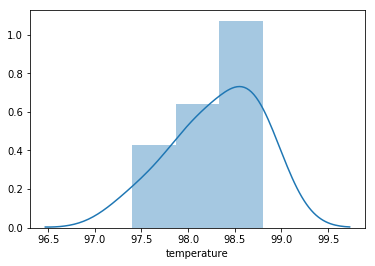

In [91]:
sns.distplot(sample)

As a rule of thumb, we use t-test when we don't know the population standard deviation, or when the sample size is less than 30. Both conditions apply in our case, we should use one-sample t-test on our 10-observation sample. As the result below shows, we fail to reject the null that the sample's true population mean is 98.6.

The result of one-sample z-test is also listed below. Contrary to the t-test result, z-test rejects the null hypothesis (the sample's true population mean is 98.6). However, the result is not reliable because our 10-observation sample is not normally distributed, which is evident in the histogram above. When we have a relatively small sample, t-test and z-test can give very different results. It is important to examine the sample carefully and choose the appropriate test. Otherwise we would reach nonsense conclusion.

#### One-Sample T-test

In [89]:
stats.ttest_1samp(sample, popmean=98.6)

Ttest_1sampResult(statistic=-2.043344741339232, pvalue=0.07137801621098319)

#### One-Sample Z-test

In [90]:
statsmodels.stats.weightstats.ztest(sample, value=98.6)

(-2.043344741339232, 0.041018323486893)

## 5. At what temperature should we consider someone's temperature to be "abnormal"?

We consider someone's temperature to be "abnormal" if it is outside of the 95% Confidence Interval. Below, we calculate confidence interval using two methods.

#### Bootstrap Confidence Interval

In [97]:
bs_replicates = draw_bs_reps(df['temperature'], np.mean, 10000)
conf_int = np.percentile(bs_replicates, [2.5, 97.5])
conf_int

array([98.12307692, 98.37461538])

#### Frequentist Confidence Interval

In [99]:
l, u = stats.norm.interval(0.95, loc=df.temperature.mean(), scale=df.temperature.std())
print("The 95% Confidence Interval is [", l, ",", u, "]")

The 95% Confidence Interval is [ 96.81221818540311 , 99.68624335305844 ]


We can further calculate margin of error.

In [100]:
me = df.temperature.mean() - l
print("The margin of error is ", me)

The margin of error is  1.4370125838276664


## 6. Is there a significant difference between males and females in normal temperature?

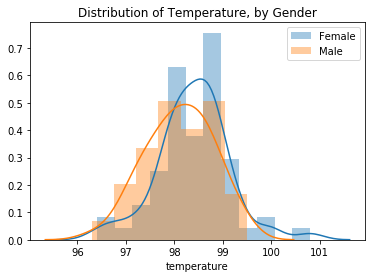

In [104]:
sns.distplot(df[df['gender']=='F']['temperature'], label='Female')
sns.distplot(df[df['gender']=='M']['temperature'], label='Male')
plt.title('Distribution of Temperature, by Gender')
plt.legend()

Above shows temperature's distribution by gender. It seems like female's temperatures are generally higher than male's. Let's verify our hypothesis using two-sample t-test. 

#### Two-Sample T-test

In [105]:
stats.ttest_ind(df[df['gender']=='F']['temperature'],df[df['gender']=='M']['temperature'])

Ttest_indResult(statistic=2.2854345381656103, pvalue=0.02393188312239561)

The null hypothesis of the test is that the mean of female temperature equals to that of male temperature and the alternative hypothesis suggests the opposite. According to the test result, p-value < 0.05, t = 2.29. We therefore reject the null at 95% confidence level and conclude that female's average temperature is greater male's, which is in line with our observation of the distribution plot above.